# Learning from images


### **CIFAR-10: A Tiny Image Dataset for Learning**

When learning computer vision, it's best to start simple. The **CIFAR-10** dataset is a classic beginner-friendly dataset for image classification.

### What is CIFAR-10?

- **CIFAR-10** contains **60,000 color images**.
- Each image is **32×32 pixels** and in **RGB**.
- Images are labeled with one of **10 classes**:
  ```
  0 - airplane     1 - automobile     2 - bird
  3 - cat          4 - deer           5 - dog
  6 - frog         7 - horse          8 - ship
  9 - truck
  ```



### Downloading with PyTorch (TorchVision)

Using PyTorch's `torchvision.datasets`, we can download and load CIFAR-10:


In [2]:
from torchvision import datasets

data_path = 'data/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

c:\Users\rsole\anaconda3\envs\cuda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


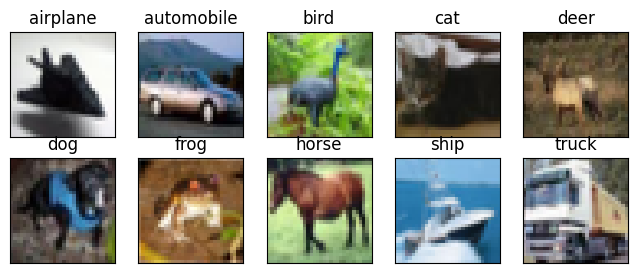

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

- `train=True` gives the **training data** (50,000 images).
- `train=False` gives the **test data** (10,000 images).
- `download=True` tells PyTorch to download it if not already present.


### What is a Dataset Object?

PyTorch wraps datasets in a class called `Dataset`, which must define two key methods:

1. `__len__`: returns the size of the dataset.
2. `__getitem__`: returns a sample (image and label) by index.


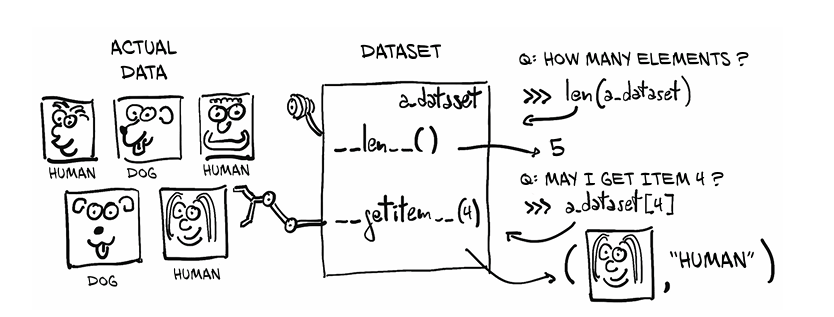

In [5]:
#Example:

len(cifar10)  # 50000
img, label = cifar10[99]


The image is returned as a **PIL image**, and the label is an **integer** (e.g., 1 = "automobile").


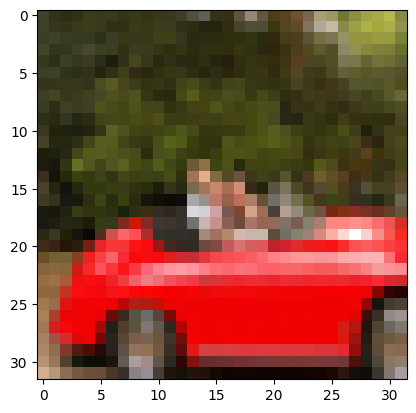

In [6]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

***Transforming Images: From PIL to PyTorch Tensor***
- Before we can use image data in a neural network, we need to convert it from a PIL image (or NumPy array) into a PyTorch tensor.

- That’s where torchvision.transforms comes in.

**What is transforms**
- The `torchvision.transforms` module provides a collection of pre-built transformation functions that we can apply to images after loading them from disk but before passing them to our model.



In [7]:
from torchvision import transforms
dir(transforms)


['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

Some useful ones:

- `ToTensor`: Converts PIL/NumPy to a PyTorch tensor

- `Normalize`: Normalizes image pixel values

- `Resize, Crop, Rotate`: Modify image shape or orientation

- `Compose`: Chains multiple transforms together

cn: To artificially increase the size of the dataset

In [8]:
#Converting an Image to a Tensor

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)  # img is a PIL image
img_t.shape
# Output: torch.Size([3, 32, 32])


torch.Size([3, 32, 32])

- The shape is now [Channels, Height, Width] (C × H × W)

- It becomes a float32 tensor with pixel values scaled from 0.0 to 1.0 (instead of 0–255)

In [9]:
img_t.min(), img_t.max()
# Output: (tensor(0.), tensor(1.))


(tensor(0.), tensor(1.))

cn: different steps in different libraries 

**Applying Transforms Directly to the Dataset**

In [10]:
tensor_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.ToTensor()
)

In [11]:
img_t, _ = tensor_cifar10[99]
type(img_t)
# Output: torch.Tensor


torch.Tensor

In [12]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

**Visualizing the Tensor Image**
- To plot the image again with matplotlib, we must reorder the dimensions from [C, H, W] to [H, W, C]

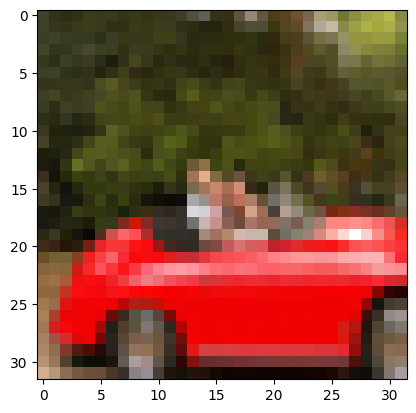

In [13]:
plt.imshow(img_t.permute(1, 2, 0))  # C×H×W → H×W×C
plt.show()


**Normalizing Image Data in PyTorch**

- To improve model training, it's important to normalize your image data so each color channel (R, G, B) has:

`Mean = 0`

`Standard Deviation = 1`

This helps models learn faster and more effectively

**Why Normalize?**
- Most activation functions (like ReLU, tanh) work best when inputs are near 0.

- Normalized data ensures balanced gradients, helping each neuron learn more efficiently.

- Each channel (Red, Green, Blue) will have similar value ranges, making training more stable.

**How to Normalize in PyTorch**
- We use transforms.Normalize() after converting the image to a tensor with ToTensor().

- But first, we need to calculate the mean and standard deviation for each channel across the dataset.

**Calculating Mean and Std for CIFAR-10**
- We load the data and stack all images into one big tensor:

In [14]:
import torch
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape  # torch.Size([3, 32, 32, 50000])


torch.Size([3, 32, 32, 50000])

Flatten all pixels in each channel and compute stats:


In [15]:
mean = imgs.view(3, -1).mean(dim=1)  # tensor([0.4915, 0.4823, 0.4468])
std = imgs.view(3, -1).std(dim=1)    # tensor([0.2470, 0.2435, 0.2616])

## (3, N * H * W)  → all pixels per channel in one row
## mean(dim=1) : Takes the mean of each row (i.e., across all pixels in each channel).

**Applying Normalize with Compose**

In [16]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
])

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transform
)


Now, each image from the dataset is automatically:

- Converted to a tensor

- Normalized across channels

**Plotting Normalized Images**
If you try to display a normalized image with matplotlib, it will look weird 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


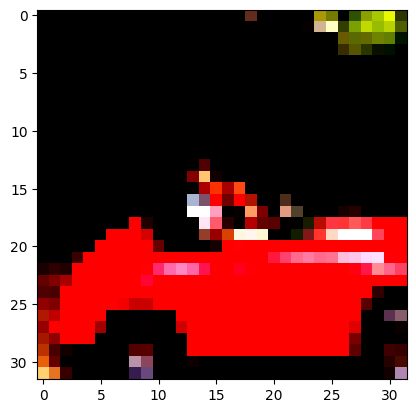

In [17]:
img_t, _ = cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))  # H × W × C
plt.show()


# Distinguishing birds from airplanes

**Building a Classifier for Birds and Airplanes**

We’re going to simplify CIFAR-10 to only classify two classes:

- `airplane (label 0)`

- `bird (label 2)`

**Step 1: Filter the CIFAR-10 Dataset**

We only need data for airplanes and birds, so we’ll:

1- Filter out the rest.

2- Remap the labels to be contiguous (airplane = 0, bird = 1).

In [18]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]


`Note:` Even though we didn’t create a custom Dataset class, our filtered list still supports len() and indexing, so it works just fine with PyTorch!

cn:master such steps

**Step 2: Flatten the Image & Build a Neural Network**
Each image is 32 × 32 pixels with 3 color channels → that’s 3,072 input features.

- We'll build a fully connected (linear) neural network:

In [19]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(3072, 512),  # Hidden layer
    nn.Tanh(),             # Nonlinear activation
    nn.Linear(512, 2)      # Output: 2 classes (airplane or bird)
)


**`First layer: 3072 inputs → 512 outputs`**

1- Activation: Tanh() helps the network learn nonlinear patterns

2- Final layer: 512 → 2 (for binary classification)

* You must have a nonlinear activation (like Tanh, ReLU, etc.) between layers to make the model learn complex patterns!

**Step 3: What Should the Output Look Like?**
Unlike regression (which outputs a number), classification is categorical. For binary classes:

- Airplane → [1.0, 0.0]

- Bird → [0.0, 1.0]

But our model won’t be perfect, so it might output something like [0.6, 0.4].

**What we want:**

- Each value is between 0 and 1

- All values sum to 1 (i.e., it's a probability distribution)

- This is exactly what the Softmax function does!
---

**Softmax: Converting Scores to Probabilities**
Softmax ensures that:

- Outputs are in the range [0, 1]

- The total adds up to 1.0

- It’s differentiable → allows learning through backpropagation

- We’ll apply it to the final layer’s output to interpret the results as class probabilities.

### Representing the output as probabilities

`softmax` is a function that turns any list (or tensor) of real numbers into a list of probabilities.

* It keeps the output in the same shape as the input.

* Each output number is between 0 and 1.

* All the output values add up to 1, just like probabilities should

Mathematically: Softmax takes each input value:

1) Applies the exponential function: exp(x)

2) Divides it by the sum of all exponentials in the list

In [20]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()


cn: why softmax, because it gives us the probabilities, and all of the probabilities add up to one. We use the  attribute with the max softmax value as the prediciton.

In [21]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)  # Output: tensor([0.0900, 0.2447, 0.6652])


tensor([0.0900, 0.2447, 0.6652])

`Important Notes`:
* Not scale-invariant: Changing the scale of input changes the softmax output distribution.

* Monotonic: Larger inputs still lead to larger outputs—but not proportionally.

`Example`:

* Input ratio 1:2 → Output ratio may not be 1:2


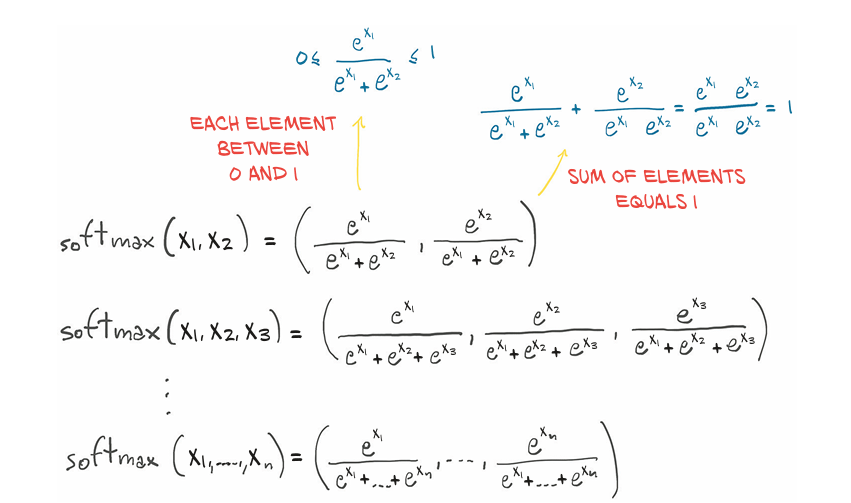

### Using Softmax in a Neural Network

You usually use Softmax at the end of your model, especially for multi-class classification.

In [22]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)


***dim=1 tells PyTorch to apply Softmax across the features (classes), not across batches***

**Batches & Prediction**

If you give a batch of images (like 2 images), PyTorch applies Softmax row-wise:


In [23]:
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])
softmax = nn.Softmax(dim=1)
softmax(x)


tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

***Image Classification Example***
1) Image of a bird is loaded and reshaped.

2) Model returns class probabilities:

In [ ]:
img, _ = cifar2[0]
img_batch = img.view(-1).unsqueeze(0) ###cn: flattens data into scalars, 

In [ ]:
out = model(img_batch) ###cn: we unsqueze to account for the batch number # adds a dimension that is related to the batch number
print(out)
print(out.shape) 
# Output: tensor([[0.4784, 0.5216]])


tensor([[0.4179, 0.5821]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 2])


3) Use argmax to find the predicted class:

In [26]:
_, index = torch.max(out, dim=1)
print(index)

tensor([1])


### A loss for classifying
* A loss function tells the model how wrong its predictions are — and guides it to improve.

* In earlier chapters, we used Mean Squared Error (MSE), which works well for regression. But when we're classifying (like distinguishing between birds and airplanes), MSE isn't ideal

***Why Not Use MSE for Classification?***
* MSE tries to make predictions exactly match values like [0.0, 1.0] or [1.0, 0.0].

* But we don’t care if the model predicts exactly 1 or 0 — we just want the correct class to have the highest probability.

* MSE penalizes small errors too much, even if the model is making the right prediction.



***What We Actually Want***
We want to:

* Reward high probability for the correct class.

* Penalize the model only when the correct class has low probability.

That’s where Negative Log Likelihood (NLL) comes in.

***NLL Loss***
* NLL loss focuses on one thing: the probability of the correct class.

* It computes:
        Loss = -log(probability of correct class)

If the model assigns a low probability, log(prob) becomes a large negative number, and we multiply by -1, making the loss big.

If the model assigns high probability, log(prob) is closer to 0, so the loss is small.

***Visualization:***
* As predicted probability → 0 → 🔺 Loss → ∞
* As predicted probability → 1 → 🔻 Loss → 0

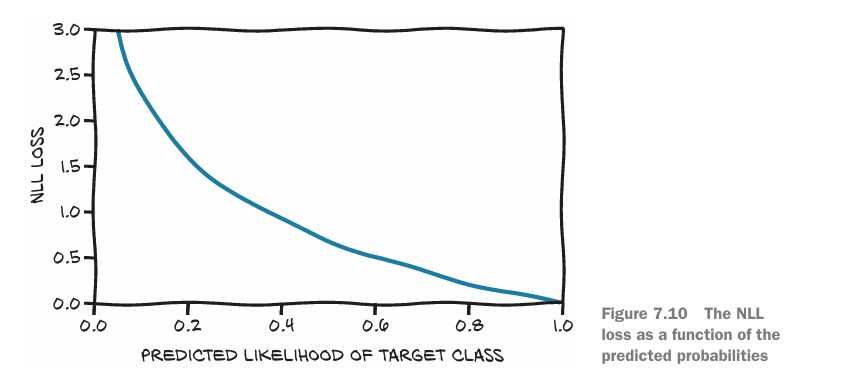

***Steps for Computing Classification Loss (Manually)***
1) Run the model to get raw outputs (called logits).

2) Apply softmax to turn logits into probabilities.

3) Pick the probability that matches the true class (e.g., class index = 0 or 1).

4) Take the log of that value.

5) Multiply by -1 → that’s your loss!

***PyTorch: Doing It Right***
PyTorch provides two better tools:

* nn.LogSoftmax → combines softmax + log in a numerically stable way

* nn.NLLLoss → expects log probabilities (not raw probabilities)

In [27]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)  # use log probabilities
)


***Loss function***

In [28]:
loss_fn = nn.NLLLoss()


In [ ]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss = loss_fn(out, torch.tensor([label]))
print(loss)  


tensor(0.7619, grad_fn=<NllLossBackward0>)


***Bonus: Why Not CrossEntropyLoss?***
Actually, PyTorch offers an even simpler alternative:
* `nn.CrossEntropyLoss`

It combines LogSoftmax + NLLLoss into one function, and takes raw logits as input.

## What is Cross Entropy Loss?

Cross Entropy Loss is used when you're doing **classification**, especially **multi-class classification**. It measures the difference between the **predicted probability distribution** and the **true distribution** (i.e., one-hot labels).



***Equation (Softmax + Cross Entropy)***

Let’s assume:
- You have `C` classes
- The true label (as one-hot) is ( y = [y_1, y_2, ..., y_C] )
- The predicted **logits** are ( z = [z_1, z_2, ..., z_C] )

First, apply **softmax** to get class probabilities:

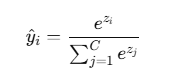


Then, compute **cross entropy loss**:

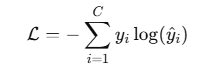


If the true label is class `k`, the formula simplifies to:

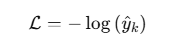



In [42]:
logits = torch.tensor([[1.5, 0.3, 2.1]])  # for 3 classes
labels = torch.tensor([2])  # true class is index 2


In [43]:
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, labels)
print(loss.item())


0.5388943552970886


## Training a Classifier: Step-by-Step Guide

***Step 1: The Training Loop***
We bring back the loop we used earlier, but this time we’re:

* Using a neural network classifier for images (e.g., birds vs. airplanes).

* Computing loss with NLL (Negative Log Likelihood).

* Updating weights with Stochastic Gradient Descent (SGD).

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss()


***Step 2: Loop Over Epochs and Data***
Each epoch means one full pass over the dataset. At each step:

1) Forward pass (predict)

2) Compute loss

3) Backward pass (compute gradients)

4) Update weights

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 10

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 5.041289
Epoch: 1, Loss: 7.797631
Epoch: 2, Loss: 8.015528
Epoch: 3, Loss: 6.398816
Epoch: 4, Loss: 10.062417
Epoch: 5, Loss: 11.344564
Epoch: 6, Loss: 5.399502
Epoch: 7, Loss: 5.298356
Epoch: 8, Loss: 10.943197
Epoch: 9, Loss: 10.040596


cn: everytime you run this it gives different values even in the first epoch, this is because the optimizer initializes the parameters to random numbers, and everytime it will be a different random number this is inconvenient because you need to be able to recreate results to experiment with different <things?> and be able to compare results. -> Need to initialize seeds

1) Question 1: How to improve the speed of execution

2) Plot the loss function and acc

3) why we have different result for different execution? what is solution

***Understanding SGD: Why We Use Batches***
* SGD = "Stochastic" Gradient Descent = uses random samples (minibatches) to estimate the gradient.

* Using one image at a time is noisy but often good enough.

* Better: use minibatches (e.g., 64 samples), which balances speed and stability.

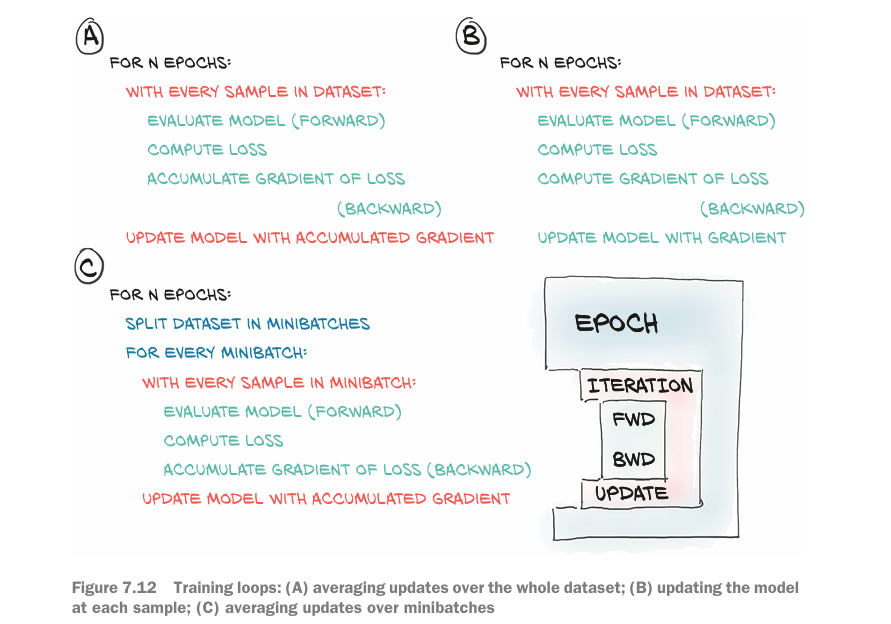




***Using DataLoader to Manage Batches***

PyTorch makes this easy with:

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)


This gives us:

* Minibatches of size 64

* Shuffling for randomness (helps generalization)

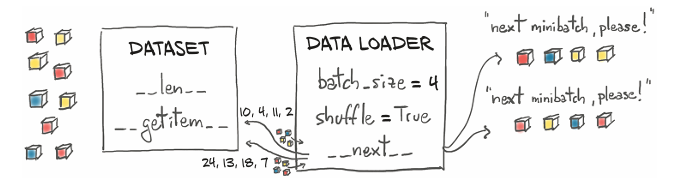


***Training with Minibatches***

In [ ]:
for epoch in range(100):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


**Now we’re computing loss & gradients over each batch, not just one image.**



**Evaluating Model Accuracy**

After training, test it on a validation set:


In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        correct += int((predicted == labels).sum())
        total += labels.shape[0]

print("Accuracy:", correct / total)


**Full Code with loader, Accuracy, and Loss Tracking**

Epoch 1/100 | Train Loss: 0.5042, Acc: 0.7699 | Val Loss: 0.4565, Acc: 0.8035
Epoch 2/100 | Train Loss: 0.4392, Acc: 0.8120 | Val Loss: 0.4343, Acc: 0.8190
Epoch 3/100 | Train Loss: 0.4116, Acc: 0.8253 | Val Loss: 0.4233, Acc: 0.8220
Epoch 4/100 | Train Loss: 0.3926, Acc: 0.8373 | Val Loss: 0.4093, Acc: 0.8290
Epoch 5/100 | Train Loss: 0.3742, Acc: 0.8435 | Val Loss: 0.4066, Acc: 0.8280
Epoch 6/100 | Train Loss: 0.3597, Acc: 0.8511 | Val Loss: 0.3990, Acc: 0.8335
Epoch 7/100 | Train Loss: 0.3446, Acc: 0.8599 | Val Loss: 0.3920, Acc: 0.8385
Epoch 8/100 | Train Loss: 0.3316, Acc: 0.8650 | Val Loss: 0.3966, Acc: 0.8385
Epoch 9/100 | Train Loss: 0.3197, Acc: 0.8740 | Val Loss: 0.3936, Acc: 0.8395
Epoch 10/100 | Train Loss: 0.3078, Acc: 0.8778 | Val Loss: 0.3959, Acc: 0.8365
Epoch 11/100 | Train Loss: 0.2961, Acc: 0.8816 | Val Loss: 0.3909, Acc: 0.8370
Epoch 12/100 | Train Loss: 0.2849, Acc: 0.8898 | Val Loss: 0.3840, Acc: 0.8410
Epoch 13/100 | Train Loss: 0.2767, Acc: 0.8940 | Val Loss: 0.

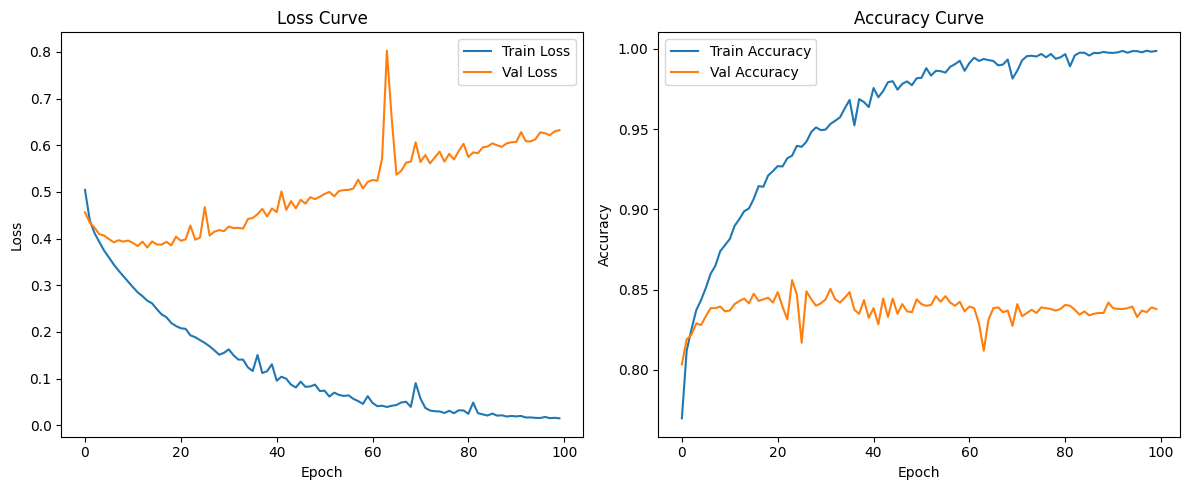

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# --- Assume cifar2 is your binary-class CIFAR dataset ---
train_size = int(0.8 * len(cifar2))
val_size = len(cifar2) - train_size
train_data, val_data = random_split(cifar2, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# --- Simple MLP Model ---
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1)
)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Metrics to track ---
n_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# --- Training Loop ---
for epoch in range(n_epochs):
    model.train()
    correct_train, total_train, epoch_train_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs.view(imgs.shape[0], -1))

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * imgs.size(0)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = epoch_train_loss / total_train
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    correct_val, total_val, epoch_val_loss = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs.view(imgs.shape[0], -1))

            loss = loss_fn(outputs, labels)
            epoch_val_loss += loss.item() * imgs.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = epoch_val_loss / total_val
    val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

# --- Plotting Loss and Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


***Results Example***
* Accuracy: ~0.79 (or 79%)

* Not bad for a simple model!

* Training loss decreases over time, showing learning.**

### Going Deeper: Bigger Models
* You can add more layers to increase learning capacity:

In [33]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)


***Full code***

And replace LogSoftmax + NLLLoss with the more convenient:

loss_fn = nn.CrossEntropyLoss()


Epoch 1/100 | Train Loss: 0.5460, Acc: 0.7385 | Val Loss: 0.4898, Acc: 0.7775
Epoch 2/100 | Train Loss: 0.4943, Acc: 0.7759 | Val Loss: 0.4679, Acc: 0.7825
Epoch 3/100 | Train Loss: 0.4771, Acc: 0.7839 | Val Loss: 0.4646, Acc: 0.7995
Epoch 4/100 | Train Loss: 0.4645, Acc: 0.7907 | Val Loss: 0.4542, Acc: 0.8035
Epoch 5/100 | Train Loss: 0.4539, Acc: 0.7960 | Val Loss: 0.4466, Acc: 0.7955
Epoch 6/100 | Train Loss: 0.4452, Acc: 0.8020 | Val Loss: 0.4375, Acc: 0.8055
Epoch 7/100 | Train Loss: 0.4357, Acc: 0.8080 | Val Loss: 0.4348, Acc: 0.7970
Epoch 8/100 | Train Loss: 0.4287, Acc: 0.8123 | Val Loss: 0.4313, Acc: 0.8060
Epoch 9/100 | Train Loss: 0.4227, Acc: 0.8159 | Val Loss: 0.4332, Acc: 0.8060
Epoch 10/100 | Train Loss: 0.4119, Acc: 0.8164 | Val Loss: 0.4335, Acc: 0.8095
Epoch 11/100 | Train Loss: 0.4098, Acc: 0.8195 | Val Loss: 0.4238, Acc: 0.8085
Epoch 12/100 | Train Loss: 0.3994, Acc: 0.8240 | Val Loss: 0.4303, Acc: 0.8085
Epoch 13/100 | Train Loss: 0.3915, Acc: 0.8287 | Val Loss: 0.

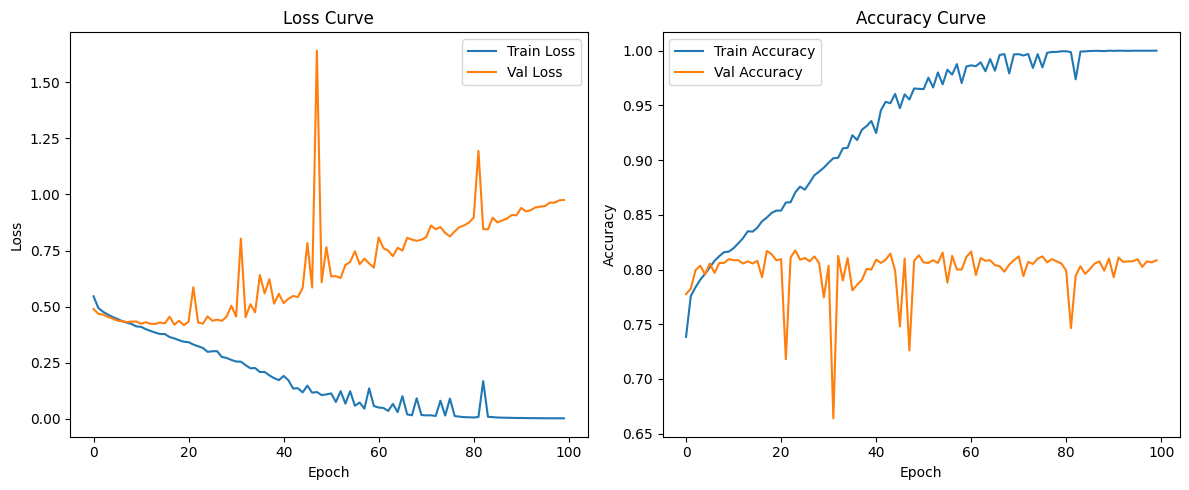

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# --- Assume cifar2 is your binary-class CIFAR dataset ---
train_size = int(0.8 * len(cifar2))
val_size = len(cifar2) - train_size
train_data, val_data = random_split(cifar2, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# --- Simple MLP Model (no LogSoftmax at the end) ---
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)  # raw logits for CrossEntropyLoss
)

# --- Use CrossEntropyLoss (no LogSoftmax needed) ---
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Metrics to track ---
n_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# --- Training Loop ---
for epoch in range(n_epochs):
    model.train()
    correct_train, total_train, epoch_train_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs.view(imgs.shape[0], -1))

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * imgs.size(0)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = epoch_train_loss / total_train
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    correct_val, total_val, epoch_val_loss = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs.view(imgs.shape[0], -1))

            loss = loss_fn(outputs, labels)
            epoch_val_loss += loss.item() * imgs.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = epoch_val_loss / total_val
    val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

# --- Plotting Loss and Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


***Overfitting Alert!***

This means the model is memorizing the training data but not generalizing well. That’s overfitting.

***How Big Is Your Model?***
You can calculate the number of parameters:


In [35]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
param_size_mb = total_params * 4 / (1024 ** 2)

print(f"Total trainable parameters: {total_params:,}")
print(f"Model size: {param_size_mb:.2f} MB")


Total trainable parameters: 3,737,474
Model size: 14.26 MB


***What About Larger Images?**

If your input image is bigger (like 1024×1024 RGB), you could easily have:

* Millions of inputs

* Billions of parameters

* Gigabytes of memory required

`That’s why fully connected models don’t scale well with image size. This is a motivation for convolutional neural networks (CNNs).`



### The Limits of Fully Connected Layers for Images

***When we use a fully connected (FC) layer, we do this:***

1) Flatten the image into a 1D vector.

2) Connect every input pixel to every output feature.

***That means:***

1) Every pixel is treated the same—there’s no understanding of where the pixel is located in the image.

2) The model sees the image as just a list of numbers — no spatial structure

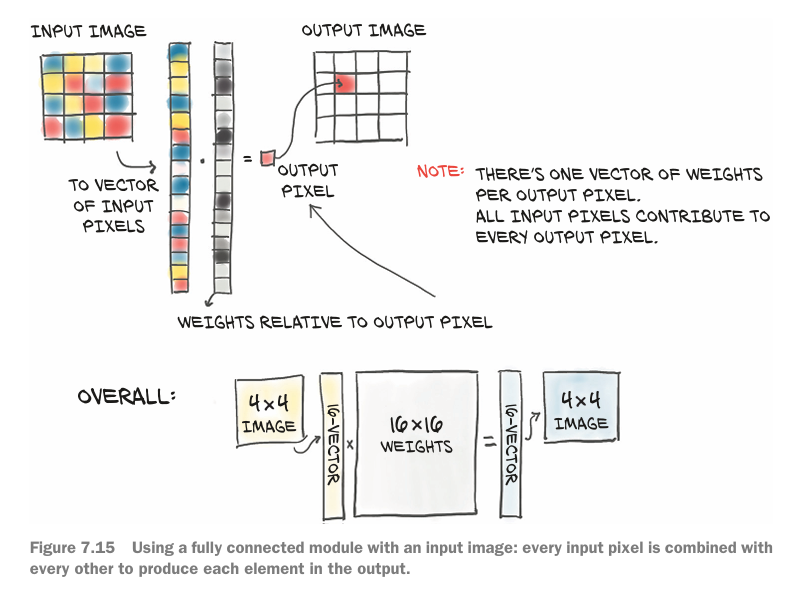

***What Does That Mean for Learning?***

Let’s say we want to recognize an airplane:

* If it appears at (row 0, col 1) and nearby pixels are dark → model learns that pattern.

* But if the airplane is shifted by 1 pixel to the right, the pattern is completely different numerically!

* The FC network doesn’t know that it’s the same shape, just shifted.

`This is called a lack of translation invariance.`

- It refers to a model’s inability to recognize the same object or feature if it appears in a different location (e.g., slightly shifted left/right/up/down).


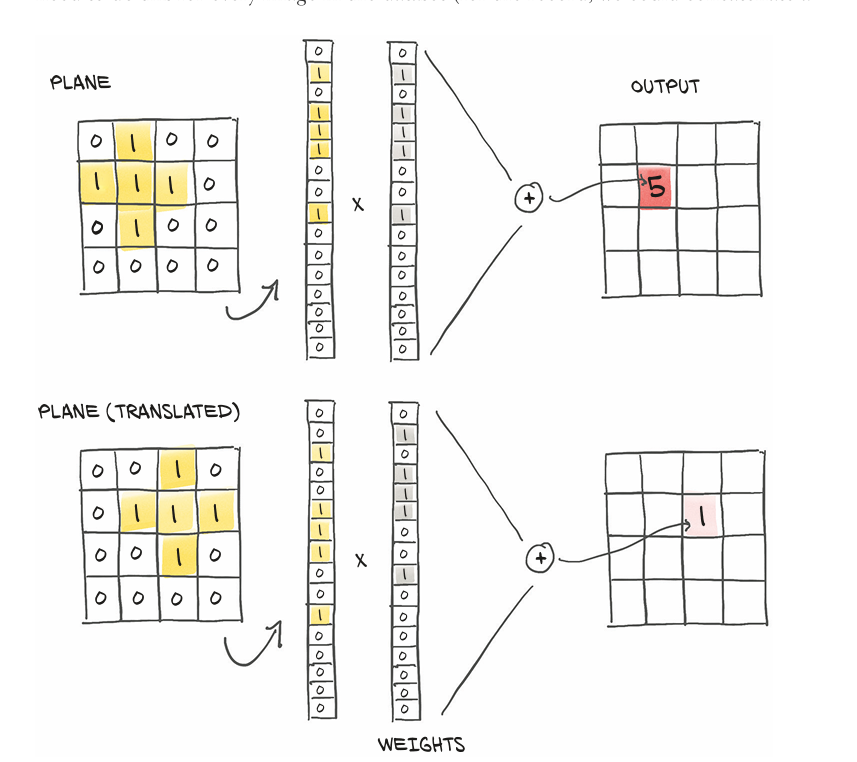

***Why Is That a Problem?***
* The model memorizes pixel combinations instead of learning the general structure of an object.

* So we need to show it every possible translation of every object.

* That means:

    1) More data 

    2) Larger models 

    3) Longer training time 

`We can do this through data augmentation (like shifting images randomly during training), but it’s inefficient.`

### Set Seed for Reproducibility

In [44]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)            # CPU
    torch.cuda.manual_seed(seed)       # Current GPU
    torch.cuda.manual_seed_all(seed)   # All GPUs (if using multi-GPU)

    # Ensures deterministic behavior (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Usage
set_seed(42)


Summary:
train model
hyper parameter, everything before training
architecture
how to def accuracy and loss functions
put it all together